# Import librairies

In [1]:
import psycopg2 as ps
import pandas.io.sql as sqlio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Import classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Import Univariate Selection Librairies
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Import Feature importance librairies
from sklearn.inspection import permutation_importance

# Import used librairies for RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Import model librairies
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

%run ../Tools.ipynb

# Connect to database

In [2]:
conn = ps.connect(dbname="SLA", user="postgres", password="root", host="localhost", port="5432")

# Get data from database

In [3]:
# Set variables to evaluate
variables = ['AGE_DEBUT', 'EVOSYMPTOM', 'WEIGHT_VAR_M12', 'ALS_VAR_M12', 'GROUPEDEB']

# Set sql query
sql = 'SELECT * FROM "PATIENTS"'

# Get data from database
df_patients = sqlio.read_sql_query(sql, conn)[variables].copy()
df_patients.shape

C:\Users\guill\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(1045, 5)

# Drop null values

In [4]:
df_patients = df_patients.dropna()
df_patients.shape

(154, 5)

# Drop "Respiratoire" Diagnostic

In [5]:
df_patients = df_patients[df_patients.GROUPEDEB != "Respiratoire"]
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 149


# Separate features and target

In [6]:
# Get features
X = df_patients.drop('GROUPEDEB', axis=1)

# Get target
y = df_patients['GROUPEDEB']

# Encode categorical data

In [7]:
# Encode categorial df_patients
X = encodeData(X)

# Scale data

In [8]:
# Normalize df_patients
X_scaled = (X - X.min())/ (X.max() - X.min())

# Features Importance Decision Tree Classifier

<Figure size 720x720 with 0 Axes>

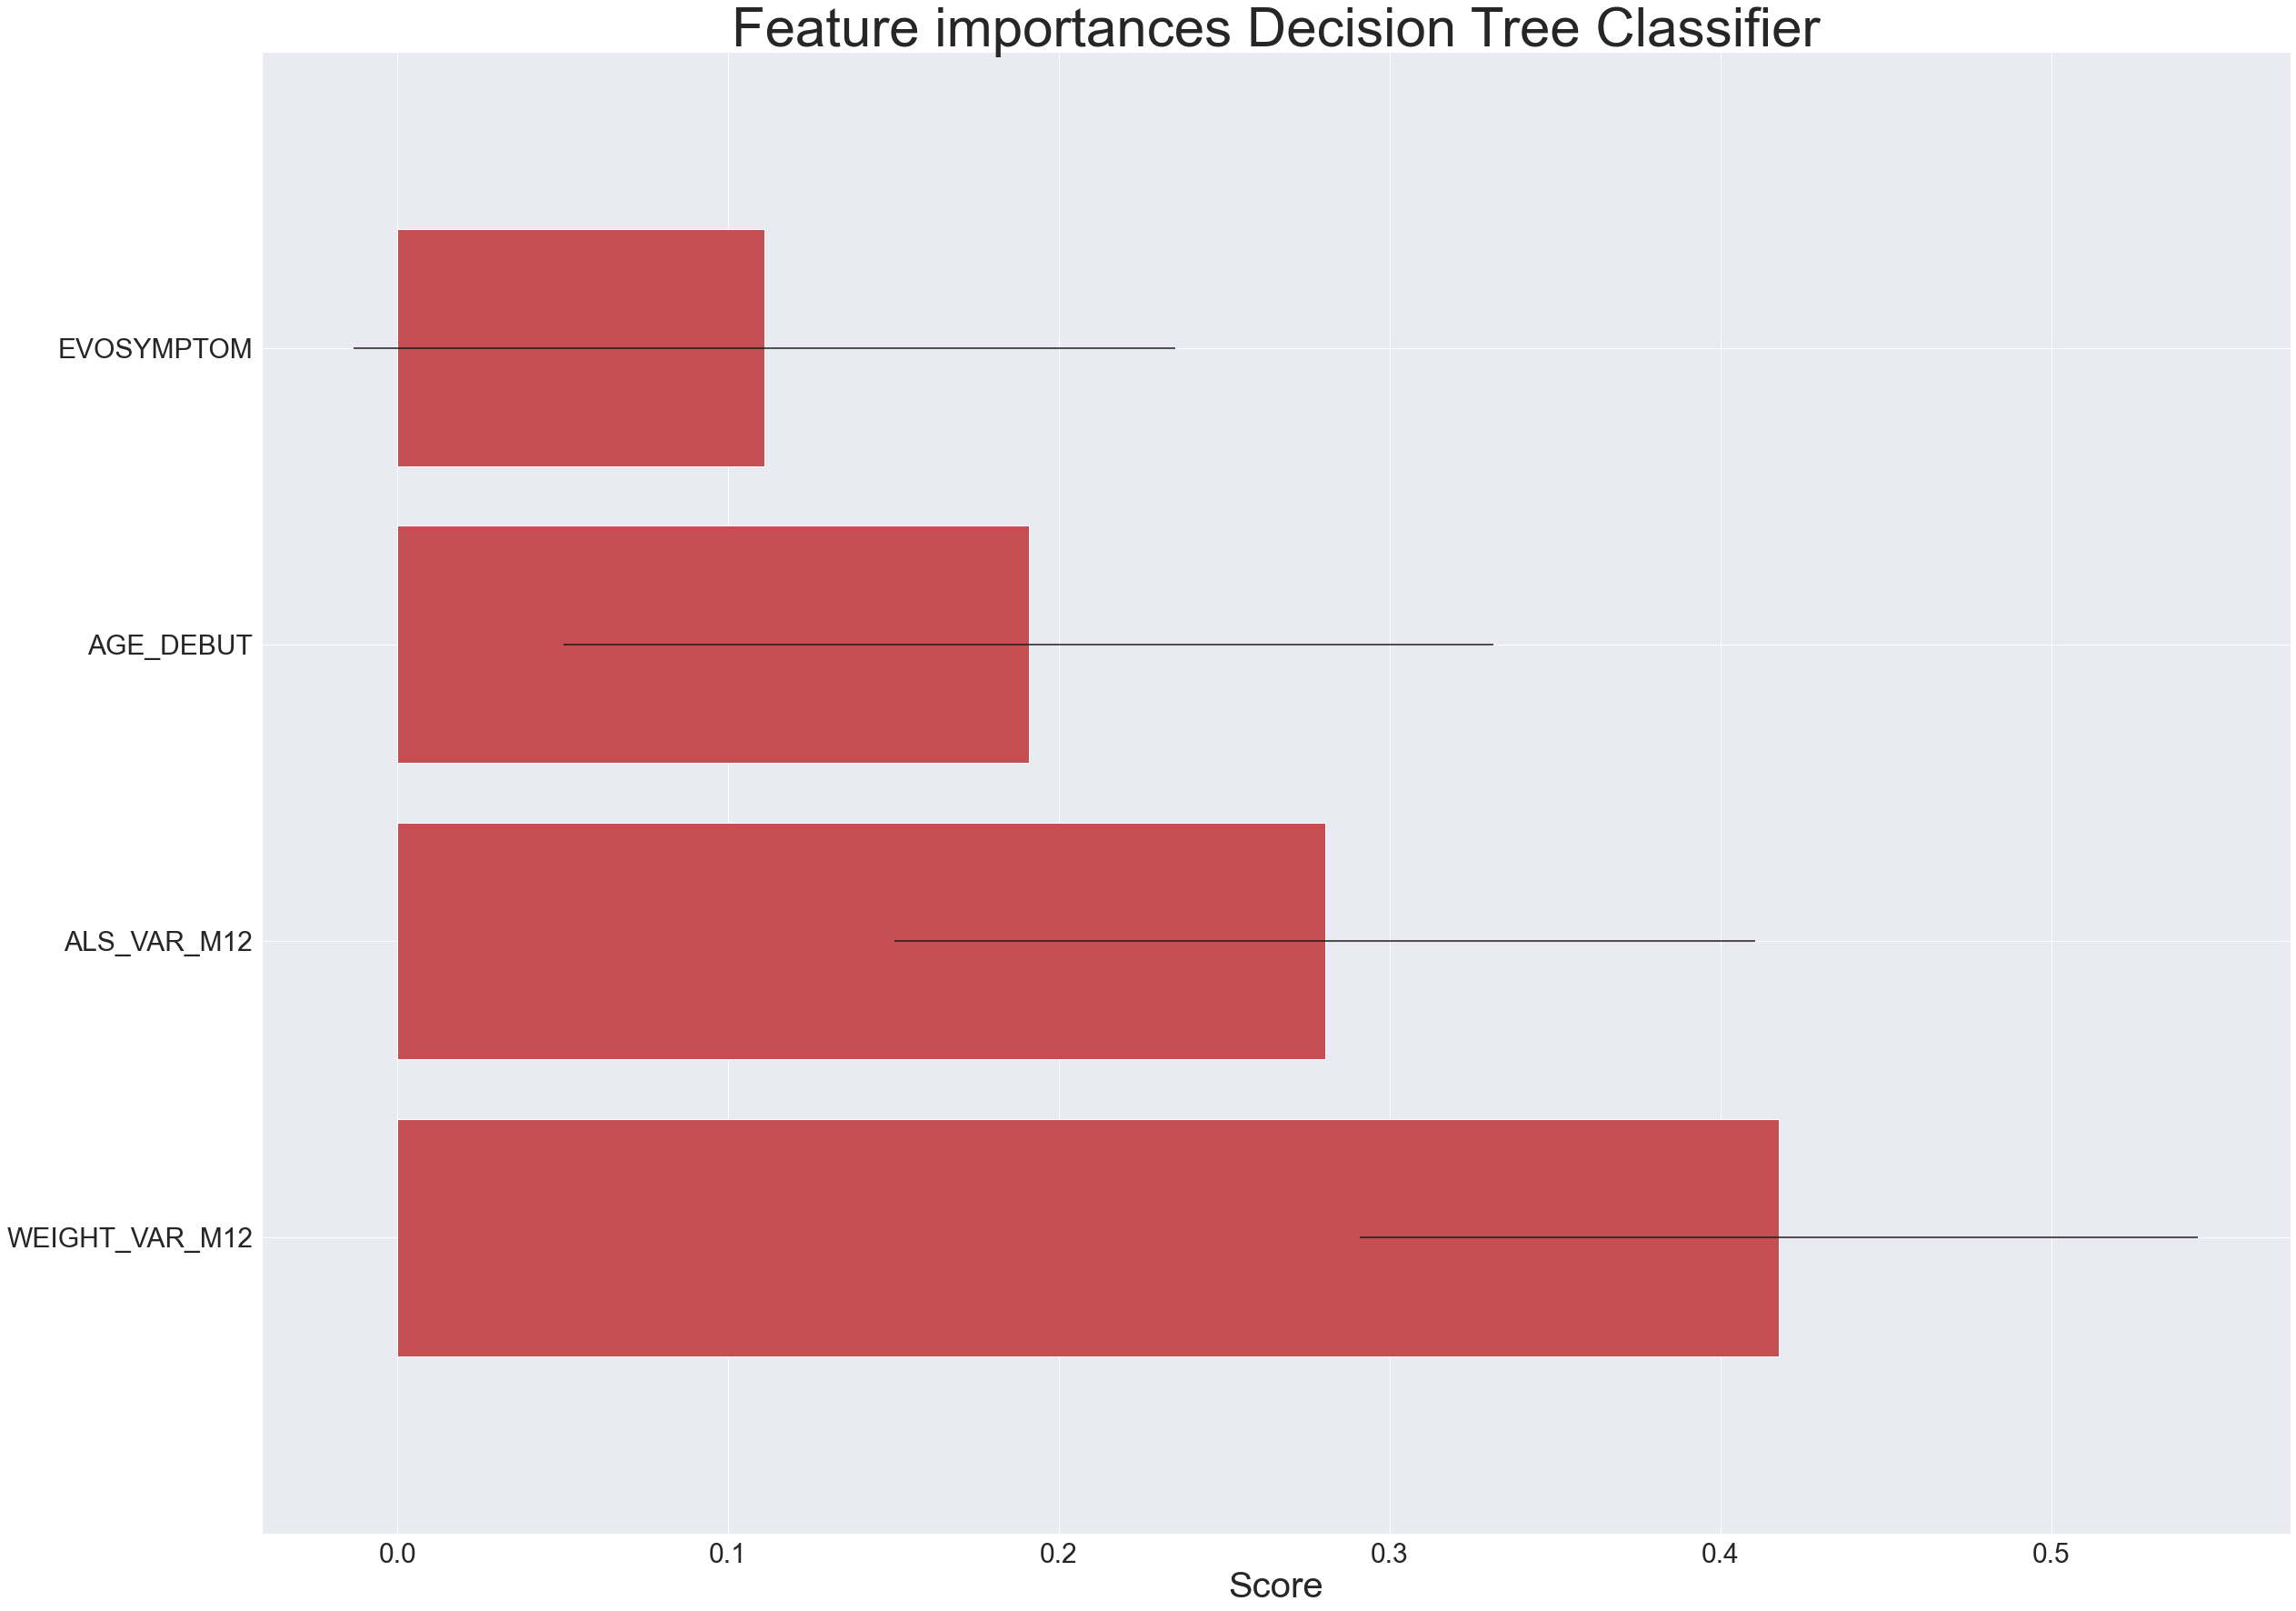

In [9]:
# Set number of iterations
n = 1000

# Array that contains feature importances for each iterations
feature_importances_array = []

# For each iteration
for i in range(0, n):
    
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    
    # Train model
    model = DecisionTreeClassifier(criterion="gini", max_depth=3)
    model.fit(X_train,y_train)
    
    # Append feature importances into an array for the iteration i
    feature_importances_array.append(model.feature_importances_)
    
# Compute importance average for each feature
avg_feature_importances = sum(feature_importances_array)/len(feature_importances_array)

# Compute standard deviation for each feature
std_feature_importances = np.std(feature_importances_array, axis = 0)

# Stock importances features
feat_importances = pd.Series(avg_feature_importances, index=X.columns)

# Create figure that will contains the bar plot
f = plt.figure(figsize=(10, 10))

# Sort each feature based on his importance mean
indices = np.argsort(avg_feature_importances)[::-1]

# Get feature names
features = model.feature_names_in_

# Plot results
plt.figure(figsize=(40, 30))
plt.title("Feature importances Decision Tree Classifier", fontsize=60)
plt.barh(range(X_test.shape[1]), avg_feature_importances[indices], color="r", xerr=std_feature_importances[indices])
plt.yticks(range(X_test.shape[1]), [features[indices[i]] for i in range(len(X.columns))], fontsize=30)
plt.xticks(fontsize=30)
plt.xlabel("Score", fontsize=40)
plt.ylim([-1, X_test.shape[1]])
plt.show()

# Feature Importance Naive Bayes

In [10]:
n = 100

importances_array = []
std_array = []

for i in range(0, n):

    # Split df_patients into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_spinal, test_size=0.2)

    # Train Naive bayes
    cnb = GaussianNB()
    cnb.fit(X_train, y_train)

    # Predict test df_patients
    y_pred_cnb = cnb.predict(X_test)

    # Compute feature importance
    imps = permutation_importance(cnb, X_test, y_test)
    
    importances = imps.importances_mean
    std = imps.importances_std
    
    importances_array.append(importances)
    std_array.append(std)
    
features = X.columns.values
avg_importances = sum(importances_array)/len(importances_array)
avg_std = sum(std_array)/len(std_array)
indices = np.argsort(avg_importances)[::-1]

# Plot results
plt.figure(figsize=(40, 30))
plt.title("Feature importances", fontsize=60)
plt.barh(range(X_test.shape[1]), avg_importances[indices], color="r", xerr=avg_std[indices])
plt.yticks(range(X_test.shape[1]), [features[indices[i]] for i in range(len(X.columns))], fontsize=30)
plt.xticks(fontsize=30)
plt.ylim([-1, X_test.shape[1]])
plt.show()

NameError: name 'y_spinal' is not defined

# Recursive feature elimination with cross-validation

In [ ]:
# Create the RFE object and compute a cross-validated score.
model = DecisionTreeClassifier(max_depth=3)

# Set metric scoring
scoring = "accuracy"

# Minimum number of features to consider
min_features_to_select = 1

# Set metric tests
test_s1_accuracies = []
test_s1_recall = []
test_s1_f1 = []

test_s2_accuracies = []
test_s2_recall = []
test_s2_f1 = []

# Set number of iterations
n = 200

for i in range(1, n):

    #=========
    # Accuracy
    #=========
    
    # Set RFECV
    rfecv = RFECV(
        estimator=model,
        step=1,
        cv=StratifiedKFold(2),
        scoring=scoring,
        min_features_to_select=min_features_to_select,
    )

    # Copy target data
    y_tmp = y.copy()

    # Map values from the target to 1 or 0
    y_tmp = y_tmp.map({'Spinal': 1, 'Bulbaire': 0}).astype(int)

    # Fit data
    rfecv.fit(X_scaled, y_tmp)
    
    # Append split test scores
    test_s1_accuracies.append(rfecv.cv_results_['split0_test_score'].tolist())
    test_s2_accuracies.append(rfecv.cv_results_['split1_test_score'].tolist())

# Set list that will have metric values
metric_values = []
metric_values.append(np.mean(test_s1_accuracies, axis=0).tolist())
metric_values.append(np.mean(test_s2_accuracies, axis=0).tolist())

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(np.transpose(metric_values)) + min_features_to_select),
    np.transpose(metric_values),
)

plt.locator_params('x', nbins = 5)
plt.show()
print("Optimal number of features : %d" % rfecv.n_features_)